In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, f1_score, recall_score,
    precision_score, roc_auc_score
)
from sklearn.preprocessing import label_binarize

# Load Dataset

In [ ]:
rule_based_df = pd.read_csv("val_results/rule_based.csv")
dnn_df = pd.read_csv("val_results/dnn.csv")

# Compare Matches

In [77]:
# Make sure both DataFrames have consistent column names
# Suppose the original label columns are 'label' and predicted columns are 'pred_rule' / 'pred_dnn'

# Rename columns in rule-based df
rule_based_df = rule_based_df.rename(columns={
    'pred_rule': 'pred_rule'    # predicted by rule-based model
})

# Rename columns in DNN df
dnn_df = dnn_df.rename(columns={
    'pred_dnn': 'pred_dnn'      # predicted by DNN
})

# Merge on review_id
merged = pd.merge(rule_based_df, dnn_df, on='review_id', suffixes=('_rule', '_dnn'))

# Columns for class probabilities
classes = ["ads", "irrelevant", "rant", "relevant", "spam"]

# Compute weighted final scores
w_rule = 0.4
w_dnn = 0.6
for cls in classes:
    merged[f"{cls}_final"] = w_rule * merged[f"{cls}_rule"] + w_dnn * merged[f"{cls}_dnn"]

# Case 1: If predictions agree → keep that label
merged["final_label"] = merged.apply(
    lambda row: row["pred_rule"] if row["pred_rule"] == row["pred_dnn"] else None, axis=1
)

# Case 2: If predictions differ → pick max weighted score
mask_disagree = merged["final_label"].isna()
merged.loc[mask_disagree, "final_label"] = merged.loc[mask_disagree, [f"{cls}_final" for cls in classes]].idxmax(axis=1)
merged["final_label"] = merged["final_label"].str.replace("_final", "")

# Now final DataFrame with true label included
score_cols = [f"{cls}_final" for cls in classes]
final = merged[["review_id", "pred_rule", "pred_dnn", "final_label", "true_label_rule"] + score_cols]

            ads  irrelevant  rant  relevant  spam
ads         249           0     0         2     0
irrelevant    0         252     0        21     0
rant          0           0   255         0     0
relevant      0           0     0      1104     0
spam          0           0     0         0   106


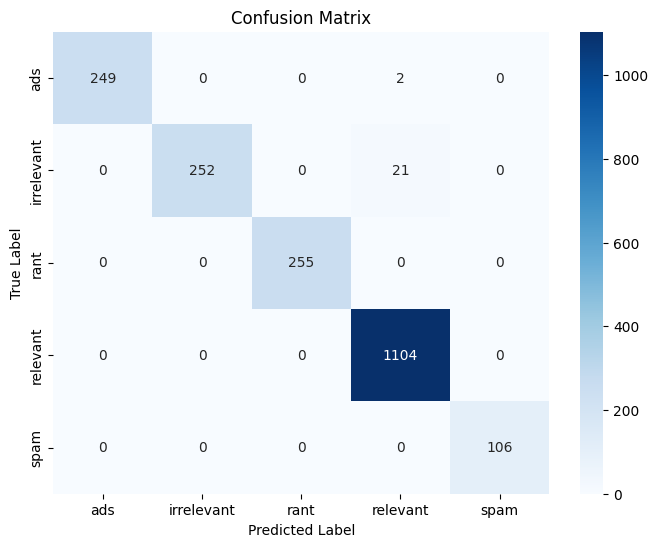

In [78]:
# final DataFrame has: review_id, final_label, true_label_rule
y_true = final["true_label_rule"]
y_pred = final["final_label"]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=classes)

# Convert to DataFrame for better readability
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print(cm_df)

# Optional: plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

Confusion Matrix:
             ads  irrelevant  rant  relevant  spam
ads         249           0     0         2     0
irrelevant    0         252     0        21     0
rant          0           0   255         0     0
relevant      0           0     0      1104     0
spam          0           0     0         0   106


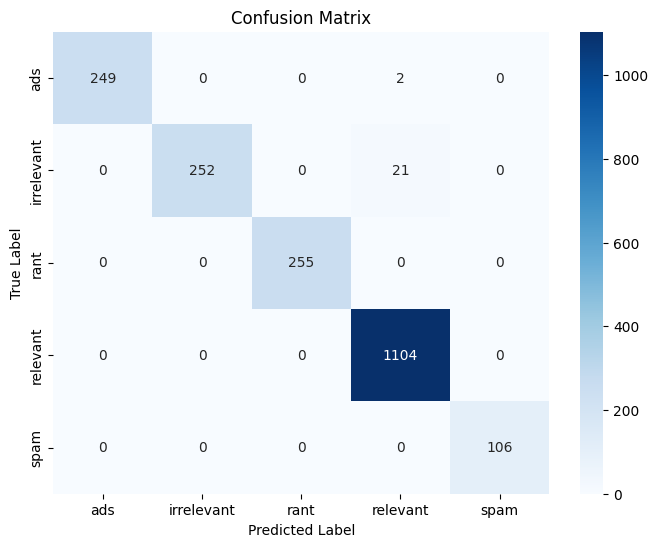

Accuracy: 0.9884364002011061


In [79]:
classes = ["ads", "irrelevant", "rant", "relevant", "spam"]

# True and predicted labels
y_true = final["true_label_rule"]
y_pred = final["final_label"]

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred, labels=classes)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
print("Confusion Matrix:\n", cm_df)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# --- Accuracy ---
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# # --- F1-score, Recall, Precision (per class & macro average) ---
# f1_per_class = f1_score(y_true, y_pred, labels=classes, average=None)
# f1_macro = f1_score(y_true, y_pred, labels=classes, average='macro')
# recall_per_class = recall_score(y_true, y_pred, labels=classes, average=None)
# recall_macro = recall_score(y_true, y_pred, labels=classes, average='macro')
# precision_per_class = precision_score(y_true, y_pred, labels=classes, average=None)
# precision_macro = precision_score(y_true, y_pred, labels=classes, average='macro')

# print("\nF1-score per class:", dict(zip(classes, f1_per_class)))
# print("F1-score (macro):", f1_macro)
# print("Recall per class:", dict(zip(classes, recall_per_class)))
# print("Recall (macro):", recall_macro)
# print("Precision per class:", dict(zip(classes, precision_per_class)))
# print("Precision (macro):", precision_macro)

# # --- ROC-AUC (One-vs-Rest / Multiclass) ---
# # You need the **probabilities or scores** per class
# # Suppose you have the weighted scores in diff_df or merged df
# y_true_bin = label_binarize(y_true, classes=classes)
# y_score = final[[f"{cls}_final" for cls in classes]].values  # numeric scores

# roc_auc = roc_auc_score(y_true_bin, y_score, average='macro', multi_class='ovr')
# print("ROC-AUC (macro, multiclass):", roc_auc)